In [1]:
# Allows us to import packages that exist one level up in the file system
# See https://stackoverflow.com/questions/34478398
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from tagnews.utils import load_data as ld
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.feature_extraction.text
import sklearn.multiclass
import sklearn.linear_model
% matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8

In [3]:
df = ld.load_data()

/home/kevin/miniconda3/envs/cjp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# TODO: Augment training data with not relevant

In [5]:
crime_df = df.ix[df.loc[:, 'OEMC':'TASR'].any(1), :]
print(crime_df.shape)
crime_df = crime_df.append(df.ix[~df['relevant'], :].sample(n=3000, axis=0))
print(crime_df.shape)

idx = np.random.permutation(crime_df.shape[0])
trn = crime_df.iloc[idx[:int(crime_df.shape[0] * 0.7)], :]
tst = crime_df.iloc[idx[int(crime_df.shape[0] * 0.7):], :]
print(trn.shape)
print(tst.shape)

(36986, 45)
(39986, 45)
(27990, 45)
(11996, 45)


/home/kevin/miniconda3/envs/cjp/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [8]:
# vectorize data
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer=LemmaTokenizer(),
                                                             binary=True)
X = vectorizer.fit_transform(trn['bodytext'].values)

Y = trn.loc[:, 'OEMC':'TASR'].values

In [9]:
X.shape

(27990, 217957)

In [17]:
from tagnews.crimetype import benchmark as bt

In [18]:
bench_results = bt.benchmark(
    lambda: sklearn.multiclass.OneVsRestClassifier(
        sklearn.linear_model.LogisticRegression()
    ),
    vectorizer.transform(crime_df['bodytext'].values),
    crime_df.loc[:, 'OEMC':'TASR'].values
)

In [19]:
fpr = pd.DataFrame(bench_results['fpr'], columns=crime_df.columns.values[7:]).T

tpr = pd.DataFrame(bench_results['tpr'], columns=crime_df.columns.values[7:]).T

ppv = pd.DataFrame(bench_results['ppv'], columns=crime_df.columns.values[7:]).T

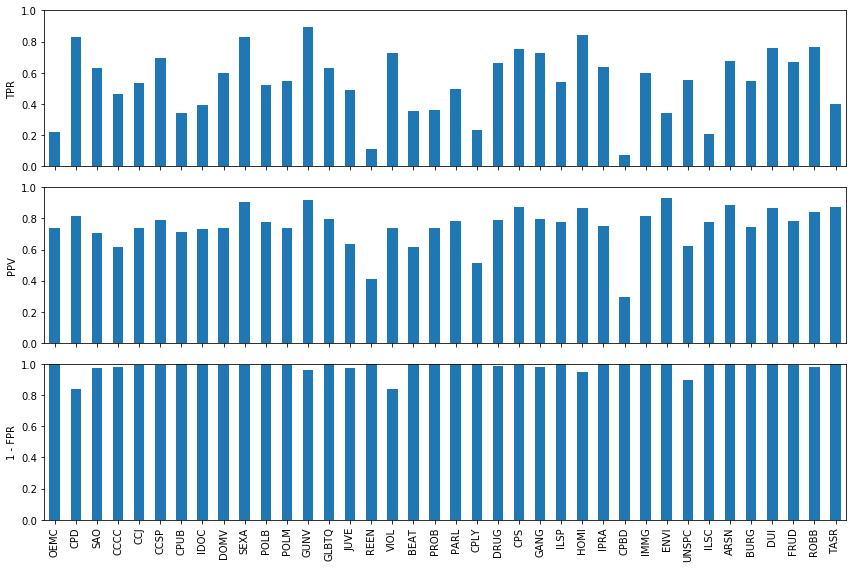

In [20]:
f, axs = plt.subplots(3,1)
tpr.mean(axis=1).plot(kind='bar', ax=axs[0])
axs[0].set_ylabel('TPR')
axs[0].set_xticklabels([])
axs[0].set_ylim([0, 1])
ppv.mean(axis=1).plot(kind='bar', ax=axs[1])
axs[1].set_ylabel('PPV')
axs[1].set_xticklabels([])
axs[1].set_ylim([0, 1])
(1 - fpr).mean(axis=1).plot(kind='bar', ax=axs[2])
axs[2].set_ylabel('1 - FPR')
axs[2].set_ylim([0, 1])
plt.tight_layout()
plt.show()

In [27]:
# this will write 10 files to the notebooks directory
bt.predict_articles(bench_results['clfs'][0], vectorizer, df, n=10)

In [104]:
# sanity check
clf = bench_results['clfs'][0]
pd.DataFrame(
    clf.predict_proba(vectorizer.transform(['marijuana'])),
    columns=df.columns[7:]
).T.sort_values(0, ascending=False)

,0
DRUG,0.846138
CPS,0.224802
VIOL,0.215430
ENVI,0.195484
CPLY,0.185326
ARSN,0.176994
GLBTQ,0.174552
REEN,0.171240
OEMC,0.167525
CPD,0.166941


In [32]:
not_yet_tagged = df.loc[df['relevant'] & ~df.loc[:, 'OEMC':'TASR'].any(1), :]

In [35]:
not_yet_tagged_preds = pd.DataFrame(
    clf.predict_proba(vectorizer.transform(not_yet_tagged.loc[:, 'bodytext'].values)),
    columns=df.columns[7:]
)

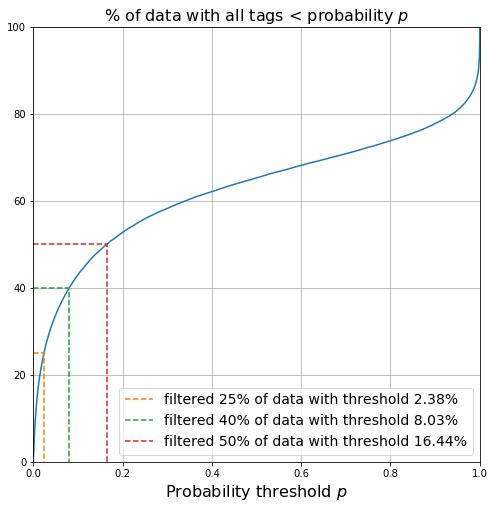

In [98]:
f, ax = plt.subplots(1, figsize=(8,8))
percents = not_yet_tagged_preds.max(axis=1).sort_values().reset_index().values[:,1]
filtered = np.linspace(0, 100, not_yet_tagged_preds.shape[0])

ax.plot(percents, filtered)

for filtered_p in [25, 40, 50]:
    p = percents[np.where(filtered >= filtered_p)[0][0]]
    plt.plot([0, p, p],
             [filtered_p, filtered_p, 0],
             '--',
             label='filtered {}% of data with threshold {:.2%}'.format(filtered_p, p))

ax.grid(True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 100])
ax.set_xlabel('Probability threshold $p$', fontsize=16)
ax.set_title('% of data with all tags < probability $p$', fontsize=16)
ax.legend(loc='lower right', fontsize=14)

In [ ]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(bench_results['clfs'][0], f)
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)